In [ ]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Load Data

X = pd.read_csv('https://raw.githubusercontent.com/renatomaaliw3/public_files/refs/heads/master/Data%20Sets/optics-01.csv')
X = X[['Feature_1', 'Feature_2']]
X

,Feature_1,Feature_2
0,-1.070650,-1.608016
1,-1.091202,-0.329115
2,-1.154062,-1.364177
3,-0.983776,-0.353938
4,-1.108507,-1.495583
...,...,...
1395,0.767370,0.815505
1396,0.976585,0.687343
1397,0.579560,0.698093
1398,0.464350,1.113255


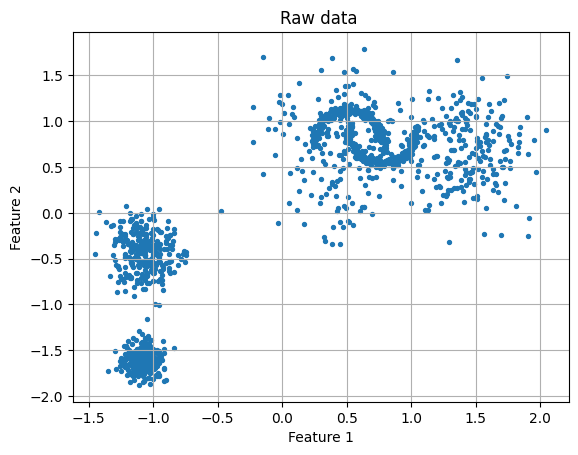

In [ ]:
# Visualize raw standardized data

plt.figure()
plt.scatter(X['Feature_1'], X['Feature_2'], s = 8)
plt.title("Raw data ")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid()
plt.show()

In [ ]:
# Key parameters:

# - min_samples: minimum number of points in a neighborhood to be considered a core point. Larger values
#   require more evidence to form clusters (more conservative).

# - xi (when using cluster_method='xi'): controls how aggressively we find steep changes in reachability,
#   which correspond to cluster boundaries. Smaller xi -> more clusters (can be fragmented). Larger xi ->
#   fewer, larger clusters.

# - min_cluster_size: optional; sets a minimum size for extracted clusters. We'll leave it 'None' so it's
#   elative to min_samples by default.

# - metric: distance metric. We'll use the default Euclidean (minkowski with p = 2).

In [ ]:
# OPTICS (initial)

optics_initial = OPTICS(min_samples = 20, xi = 0.05, cluster_method = "xi")
optics_initial.fit(X)

OPTICS(min_samples=20)

In [ ]:
# Labels and Clusters

labels_initial = optics_initial.labels_
# n_clusters_initial = len(set(labels_initial)) - (1 if -1 in labels_initial else 0)
noise_initial = np.mean(labels_initial == -1)

labels_initial

array([ 0,  1,  0, ..., -1,  2,  2])

In [ ]:
# Reachability plot: small values = points reachable from nearby dense regions.
# Long plateaus of low reachability indicate clusters; big jumps suggest cluster boundaries.

order = optics_initial.ordering_
reachability = optics_initial.reachability_[order]

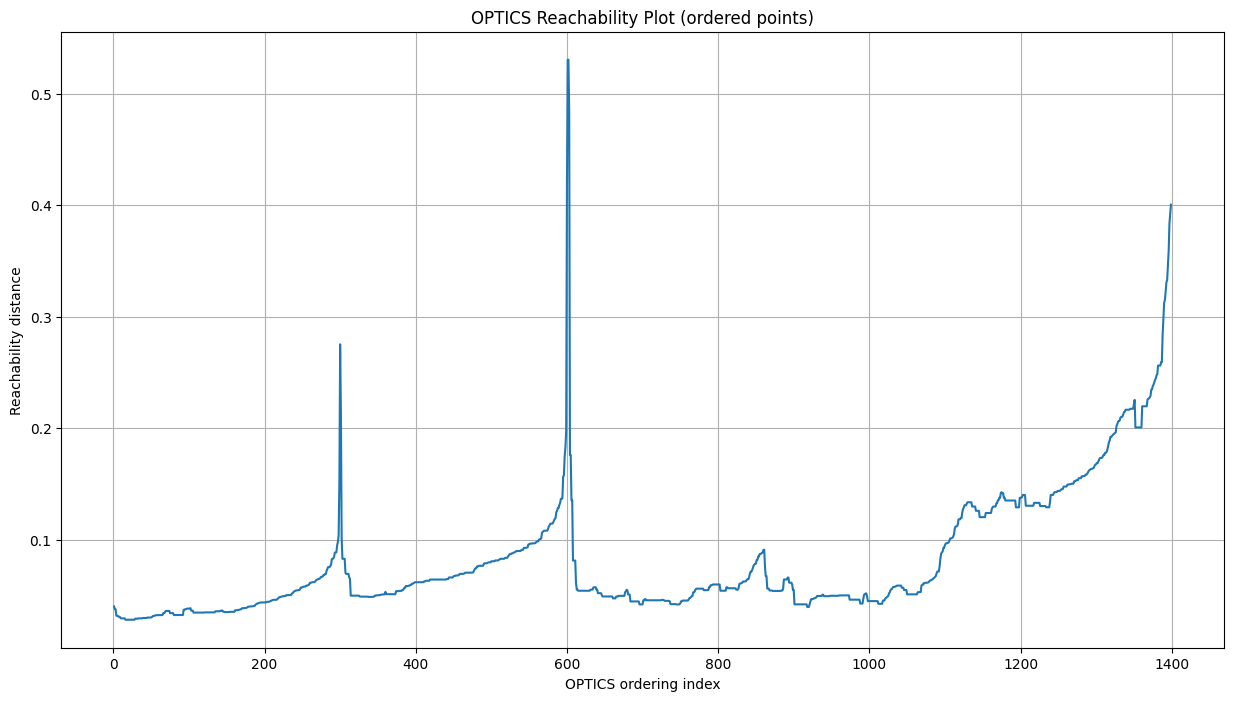

In [ ]:
# Visualization

plt.figure(figsize = (15, 8))
plt.plot(reachability)
plt.title("OPTICS Reachability Plot (ordered points)")
plt.xlabel("OPTICS ordering index")
plt.ylabel("Reachability distance")
plt.grid()
plt.show()

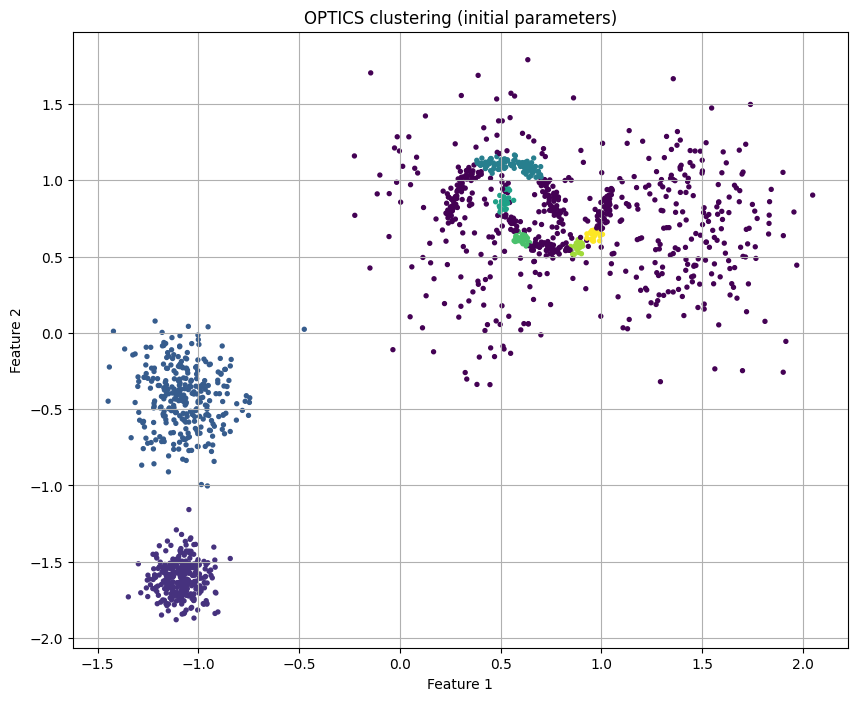

In [ ]:
# Cluster labels in 2D

plt.figure(figsize = (10, 8))
plt.scatter(X['Feature_1'], X['Feature_2'], c = labels_initial, s = 8)
plt.title("OPTICS clustering (initial parameters)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid()
plt.show()

In [ ]:
# Explore OPTICS parameters using visual diagnostics + silhouette score

min_samples_grid = [5, 10, 20, 50]
xi_grid = [0.02, 0.05, 0.1, 0.2]

results_optics = []

for ms in min_samples_grid:

    for xi in xi_grid:

        model = OPTICS(min_samples=ms, xi=xi, cluster_method="xi")
        model.fit(X)
        labels = model.labels_

        # Evaluate
        mask = labels != -1
        labeled = X[mask]
        labeled_labels = labels[mask]
        n_clusters = len(set(labeled_labels))
        noise_frac = 1.0 - (np.sum(mask) / len(X))

        if n_clusters >= 2 and len(labeled) > n_clusters:

            sil = silhouette_score(labeled, labeled_labels)

        else:

            sil = np.nan  # can't compute a meaningful silhouette

        results_optics.append({

            "min_samples": ms,
            "xi": xi,
            "n_clusters": n_clusters,
            "noise_frac": noise_frac,
            "silhouette": sil
        })

df_optics = pd.DataFrame(results_optics).sort_values(["min_samples", "xi"]).reset_index(drop=True)

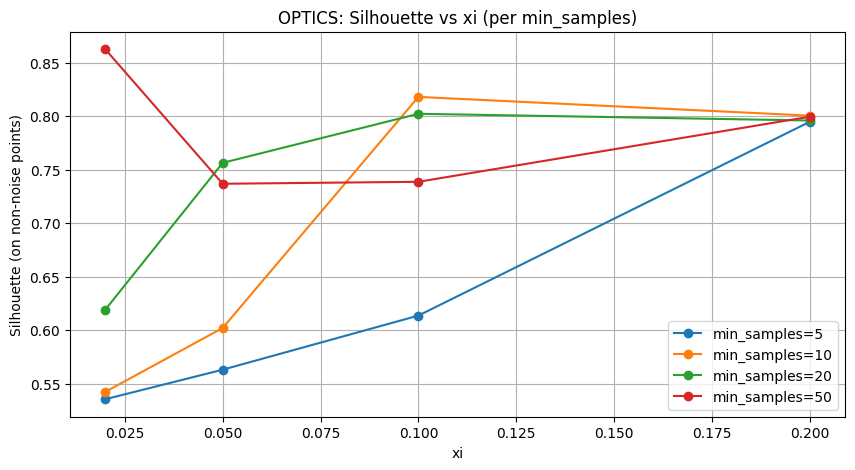

In [ ]:
# Plot silhouette vs xi for each min_samples (one figure, multiple lines)
plt.figure(figsize = (10, 5))

for ms in min_samples_grid:

    ys = []
    for xi in xi_grid:
        row = df_optics[(df_optics["min_samples"] == ms) & (df_optics["xi"] == xi)]
        ys.append(float(row["silhouette"].values[0]))
    plt.plot(xi_grid, ys, marker="o", label=f"min_samples={ms}")

plt.title("OPTICS: Silhouette vs xi (per min_samples)")
plt.xlabel("xi")
plt.ylabel("Silhouette (on non-noise points)")
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Choose the "best" OPTICS by silhouette (tie-breaker: fewer noise, then more clusters)

df_optics_eval = df_optics.copy()

# Replace NaN silhouettes with very low values so they don't win

df_optics_eval["silhouette_filled"] = df_optics_eval["silhouette"].fillna(-999)
best_row = df_optics_eval.sort_values(
    ["silhouette_filled", "noise_frac", "n_clusters"],
    ascending=[False, True, False]
)

,min_samples,xi,n_clusters,noise_frac,silhouette,silhouette_filled
12,50,0.02,3,0.514286,0.862396,0.862396
6,10,0.10,7,0.931429,0.817897,0.817897
10,20,0.10,3,0.554286,0.802130,0.802130
7,10,0.20,2,0.572857,0.800400,0.800400
15,50,0.20,2,0.572143,0.799413,0.799413
11,20,0.20,2,0.570714,0.795879,0.795879
3,5,0.20,20,0.896429,0.794694,0.794694
9,20,0.05,7,0.446429,0.756346,0.756346
14,50,0.10,3,0.002857,0.738664,0.738664
13,50,0.05,3,0.001429,0.736832,0.736832


In [ ]:
# Best Parameters

best_ms = int(best_row["min_samples"])
best_xi = float(best_row["xi"])

optics_best = OPTICS(min_samples = best_ms, xi = best_xi, cluster_method = "xi")
optics_best.fit(X)
labels_optics_best = optics_best.labels_

print({best_ms}) # min_samples
print({best_xi}) # xi
print({best_row['silhouette']}) # silhouette
print({int(best_row['n_clusters'])}) # clusters
print({best_row['noise_frac']}) # noise frac

{50}
{0.02}
{np.float64(0.8623963690247044)}
{3}
{np.float64(0.5142857142857142)}


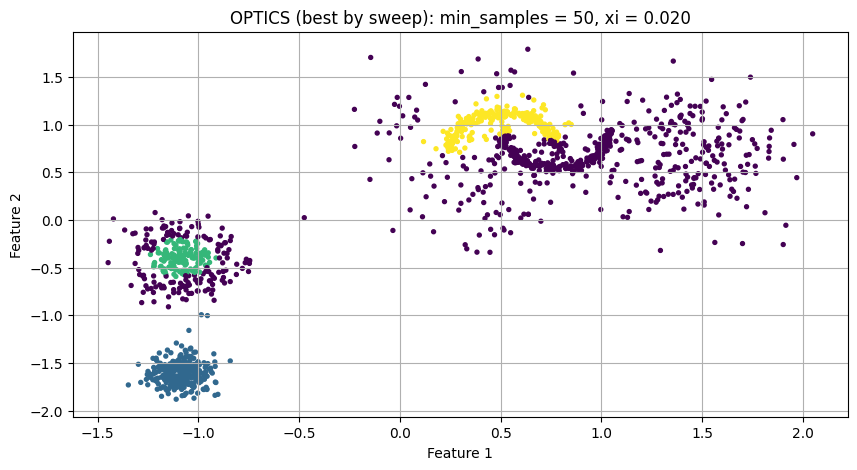

In [ ]:
# Visualize

plt.figure(figsize = (10,5))
plt.scatter(X['Feature_1'], X['Feature_2'], c = labels_optics_best, s = 8)
plt.title(f"OPTICS (best by sweep): min_samples = {best_ms}, xi = {best_xi:.3f}")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid()
plt.show()